<a href="https://colab.research.google.com/github/probml/dynamax/blob/main/dynamax/rebayes/demos/orfit_1d_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ORFit Regression Demo

# 0. Imports and Load Dataset

In [2]:
# %pip install augly
# %pip install pylibmagic
# %pip install flax
# %pip install tqdm
# %pip install -qq git+https://github.com/probml/dynamax.git

In [3]:
from typing import Sequence
from functools import partial
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import jacrev
from jax import vmap
import flax.linen as nn
from jax.flatten_util import ravel_pytree
from tensorflow_probability.substrates.jax.distributions import Normal
from tqdm import tqdm

import pylibmagic
from dynamax.utils.datasets import load_1d_synthetic_dataset
from dynamax.rebayes.ekf import RebayesEKF
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
from dynamax.rebayes.orfit import ORFitParams, orthogonal_recursive_fitting

# 1. MLP Model

In [4]:
# Define MLP model that uses gelu activation function
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.gelu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

def get_mlp_flattened_params(model_dims, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    flat_params, unflatten_fn = ravel_pytree(params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

# 2. Posterior Predictive

## 2.1 ORFit

In [5]:
def orfit_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_basis):
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    FU = F @ post_basis
    pred_cov = F @ F.T - FU @ FU.T

    return pred_mean, pred_cov

In [6]:
def orfit_plot_prediction(ax, post_mean, post_basis, apply_fn, featurize_fn, 
                          X_train, y_train, X_eval, y_eval, obs_noise=False, 
                          plot_title=''):
    # Predict
    X_features = vmap(featurize_fn)(X_eval)
    pred_means, pred_covs = vmap(
        orfit_posterior_predictive_moments, (None, 0, None, None)
    )(apply_fn, X_features, post_mean, post_basis)
    pred_means, pred_covs = pred_means.squeeze(), pred_covs.squeeze()

    # Plot predictions
    ax.plot(X_eval, pred_means, label='mean');
    if obs_noise:
        ax.scatter(X_train, y_train, c='k', label='data', alpha=0.8);
    else:
        ax.plot(X_eval, y_eval, 'r--', label='true function')
        ax.plot(X_train, y_train, 'kx', label='data', alpha=0.8);
    ax.fill_between(X_eval.squeeze(), pred_means - 2.0*jnp.sqrt(pred_covs), 
                    pred_means + 2.0*jnp.sqrt(pred_covs), alpha=0.5, label='1 std');
    # ax.set_xlim(-3.0, 3.0)
    # ax.set_ylim(-5.0, 3.0)
    ax.set_title(plot_title)
    return ax

## 2.2 EKF

In [7]:
def mean_cov_callback(bel, t, x, y):
    return bel.mean, bel.cov

def run_ekf(X, Y, ekf_params, type='fcekf', callback=mean_cov_callback):
    estimator = RebayesEKF(ekf_params, method = type)
    _, filtered_means = estimator.scan(X, Y, callback=callback)

    return filtered_means

In [8]:
def linearized_posterior_predictive_moments_diagonal(apply_fn, x_to_pred, post_mean, post_cov, obs_noise=0.0):
    """Compute posterior predictive moments for a single input x_to_pred"""
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    pred_cov = (F * post_cov) @ F.T + obs_noise

    return pred_mean, pred_cov

In [9]:
def linearized_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_cov, obs_noise=0.0):
    """Compute posterior predictive moments for a single input x_to_pred"""
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    pred_cov = F @ post_cov @ F.T + obs_noise

    return pred_mean, pred_cov


In [10]:
def plot_predictions(X_train, y_train, X_eval, initial_var, emission_var, 
                     flat_params, apply_fn, ekf_type='fcekf'):
    state_dim = flat_params.size
    ekf_params = ParamsGGSSM(
        initial_mean=flat_params,
        initial_covariance=jnp.eye(state_dim) * initial_var,
        dynamics_function=lambda w, _: w,
        dynamics_covariance = jnp.eye(state_dim) * 0,
        emission_mean_function = lambda w, x: apply_fn(w, x),
        emission_cov_function = lambda w, x: jnp.array([emission_var]),
    )
    # Train EKF
    ekf_post = run_ekf(X_train, y_train, ekf_params, type=ekf_type)
    ekf_mean, ekf_cov = ekf_post[0][-1], ekf_post[1][-1]

    # Predict
    if len(ekf_cov.shape) == 2:
        posterior_predictive_fn = linearized_posterior_predictive_moments
    else:
        posterior_predictive_fn = linearized_posterior_predictive_moments_diagonal
    pred_means, pred_covs = vmap(
        posterior_predictive_fn, (None, 0, None, None, None)
    )(apply_fn, X_eval, ekf_mean, ekf_cov, emission_var)
    pred_means, pred_covs = pred_means.squeeze(), pred_covs.squeeze()

    # Plot predictions
    fig, ax = plt.subplots()
    ax.plot(X_eval, pred_means, label='mean');
    ax.plot(X_train, y_train, 'kx', label='data', alpha=0.8);
    ax.fill_between(X_eval.squeeze(), pred_means - 2.0 * jnp.sqrt(pred_covs), pred_means + 2.0 * jnp.sqrt(pred_covs), alpha=0.5, label='1 std');
    # ax.set_xlim(-3.0, 3.0)
    # ax.set_ylim(-3.0, 3.0)
    ax.set_title(f'{ekf_type.upper()} predictions')

# 2. Linear Regression

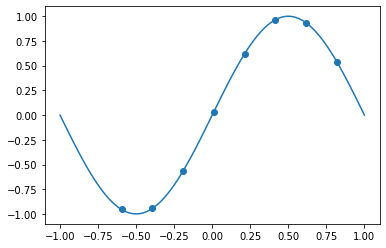

In [11]:
# Sinusoidal Dataset
n1_samples = 100
X1_grid = jnp.linspace(-1.0, 1.0, n1_samples)
y1_true = jnp.sin(jnp.pi*X1_grid)

# Select some samples as training set
sampled_indices = jr.permutation(jr.PRNGKey(0), jnp.arange(n1_samples//5, n1_samples, 10))
n1_train = len(sampled_indices)
X1_train, y1_train = X1_grid[sampled_indices], y1_true[sampled_indices]

fig, ax = plt.subplots()
ax.plot(X1_grid, y1_true)
ax.scatter(X1_train, y1_train);

In [12]:
# Feature set is polynomial of order 20
poly_order1 = 20
def x_to_feature(x, order=poly_order1):
    return jnp.power(x, jnp.arange(1, order+1))

X1_featurized = vmap(x_to_feature)(X1_train)

In [13]:
# Define the linear regression model
input_dim1, hidden_dims1, output_dim1 = poly_order1, [], 1
model_dims1 = [input_dim1, *hidden_dims1, output_dim1]
_, flat_params1, _, apply_fn1 = get_mlp_flattened_params(model_dims1)
print(flat_params1.shape)

(21,)


In [14]:
# Train ORFit on the dataset
orfit_params1 = ORFitParams(
    initial_mean=flat_params1,
    apply_function=apply_fn1,
    loss_function=lambda w, x, y: (apply_fn1(w, x) - y) ** 2,
    memory_size=n1_train
)
orfit_posterior1 = orthogonal_recursive_fitting(orfit_params1, y1_train, X1_featurized)

In [26]:
def animate_orfit(orfit_posterior, apply_fn, featurize_fn, X_train, y_train, 
                  X_grid, y_true, obs_noise, total_iter, i):
    filtered_means, filtered_bases = orfit_posterior.filtered_means, orfit_posterior.filtered_bases

    ax.cla()

    orfit_plot_prediction(ax, filtered_means[i], filtered_bases[i], apply_fn, 
                          featurize_fn, X_train[:i+1], y_train[:i+1], X_grid, y_true, 
                          obs_noise=obs_noise, plot_title=f'ORFit (Training Data {i+1}/{total_iter})')
    ax.set_ylim(-3.0, 3.0)
    
    return ax

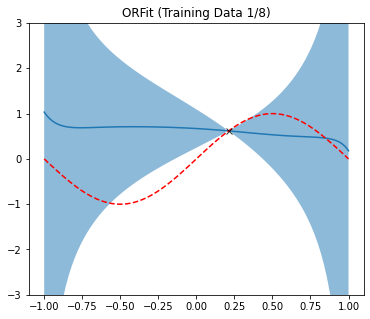

In [27]:
animate_lr1 = lambda i: animate_orfit(orfit_posterior1, apply_fn1, x_to_feature, 
                                      X1_train, y1_train, X1_grid, y1_true, False, 
                                      n1_train, i)

fig, ax = plt.subplots(figsize=(6, 5))
anim1 = animation.FuncAnimation(fig, animate_lr1, frames=n1_train, interval=600)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [28]:
HTML(anim1.to_html5_video())

# 3. Non-Linear Regression

## 3.0 Datasets

In [18]:
n2_train=200
n2_test=400

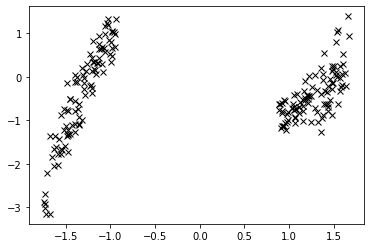

In [21]:
# Dataset 1
(X2_train, y2_train), (X2_test, y2_test) = load_1d_synthetic_dataset(n_train=n2_train, n_test=n2_test)
X2_train, y2_train = X2_train.squeeze(), y2_train.squeeze()
shuffle_indx = jr.permutation(jr.PRNGKey(0), jnp.arange(X2_train.shape[0]))
X2_train, y2_train = X2_train[shuffle_indx], y2_train[shuffle_indx]
X2_grid = jnp.linspace(-2.5, 2.5, 200)

fig, ax = plt.subplots()
ax.plot(X2_train, y2_train, 'kx', label='data');
# ax.plot(X2_test, y2_test, 'rx', label='data');
# ax.set_xlim(-0.5, 1.0)
# ax.set_ylim(-0.5, 1.0);

## 3.1 Simple MLP

### 3.1.1 PPD Sweep over Memory Size

In [22]:
# Define the MLP model
input_dim2, hidden_dims2, output_dim2 = 1, [50,], 1
model_dims2 = [input_dim2, *hidden_dims2, output_dim2]
_, flat_params2, _, apply_fn2 = get_mlp_flattened_params(model_dims2)
print(flat_params2.shape)

(151,)


In [23]:
def animate_per_memory_size(flat_params, apply_fn, X_train, y_train, X_grid, y_llim, y_ulim, i, mlp_type):
    ax.cla()
    # Train ORFit on the dataset
    orfit_params = ORFitParams(
        initial_mean=flat_params,
        apply_function=apply_fn,
        loss_function=lambda w, x, y: (apply_fn(w, x) - y) ** 2,
        memory_size=i+1
    )
    before = time.time()
    orfit_posterior = orthogonal_recursive_fitting(orfit_params, y_train, X_train)
    orfit_filtered_mean = orfit_posterior.filtered_means[-1]
    orfit_filtered_basis = orfit_posterior.filtered_bases[-1]
    clear_output(wait=True)
    print(f'Time taken for step {i+1}: {time.time() - before}')
    orfit_plot_prediction(ax, orfit_filtered_mean, orfit_filtered_basis, apply_fn, lambda x: x,
                          X_train, y_train, X_grid, None, True, 
                          plot_title=f'ORFit-{mlp_type} MLP (Memory Size {i+1}/100)')
    ax.set_ylim(y_llim, y_ulim)
    
    return ax

animate_nlr1 = lambda i: animate_per_memory_size(flat_params2, apply_fn2, X2_train, y2_train, X2_grid, -6.0, 5.0, i, 'Simple')

Time taken for step 1: 0.6665101051330566


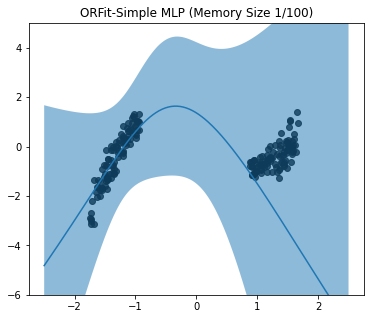

In [24]:
fig, ax = plt.subplots(figsize=(6, 5))
anim2 = animation.FuncAnimation(fig, animate_nlr1, frames=100)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [25]:
HTML(anim2.to_html5_video())

Time taken for step 100: 0.8198974132537842


### 3.1.2 PPD Sweep over Training Set

#### 3.1.2.1 Memory Size 10

In [29]:
# Train Full-Memory ORFit on the dataset
orfit_params2 = ORFitParams(
    initial_mean=flat_params2,
    apply_function=apply_fn2,
    loss_function=lambda w, x, y: (apply_fn2(w, x) - y) ** 2,
    memory_size=10
)
orfit_posterior2 = orthogonal_recursive_fitting(orfit_params2, y2_train, X2_train)

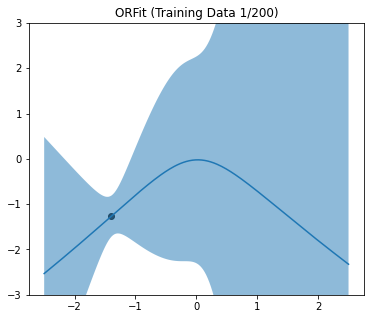

In [30]:
animate_nlr2 = lambda i: animate_orfit(orfit_posterior2, apply_fn2, lambda x: x, 
                                       X2_train, y2_train, X2_grid, None, True, 
                                       n2_train, i)

fig, ax = plt.subplots(figsize=(6, 5))
anim3 = animation.FuncAnimation(fig, animate_nlr2, frames=n2_train)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [31]:
HTML(anim3.to_html5_video())

#### 3.1.2.2 Inifinite Memory

In [32]:
# Train Full-Memory ORFit on the dataset
orfit_params3 = ORFitParams(
    initial_mean=flat_params2,
    apply_function=apply_fn2,
    loss_function=lambda w, x, y: (apply_fn2(w, x) - y) ** 2,
    memory_size=n2_train
)
orfit_posterior3 = orthogonal_recursive_fitting(orfit_params3, y2_train, X2_train)

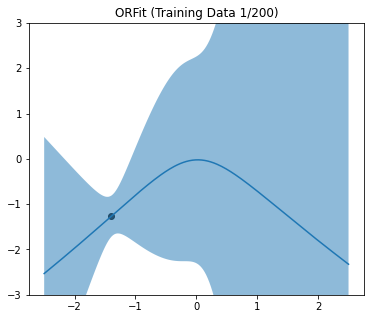

In [33]:
animate_nlr3 = lambda i: animate_orfit(orfit_posterior3, apply_fn2, lambda x: x, 
                                       X2_train, y2_train, X2_grid, None, True, 
                                       n2_train, i)

fig, ax = plt.subplots(figsize=(6, 5))
anim4 = animation.FuncAnimation(fig, animate_nlr3, frames=n2_train)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [34]:
HTML(anim4.to_html5_video())

## 3.2 Deeper/Wider MLP

### 3.2.1 PPD Sweep over Memory Size

In [52]:
# Define the MLP model
input_dim3, hidden_dims3, output_dim3 = 1, [150, 150, 150,], 1
model_dims3 = [input_dim3, *hidden_dims3, output_dim3]
_, flat_params3, _, apply_fn3 = get_mlp_flattened_params(model_dims3)
print(flat_params3.shape)

(45751,)


In [53]:
animate_nlr4 = lambda i: animate_per_memory_size(flat_params3, apply_fn3, X2_train, y2_train, X2_grid, -6.0, 5.0, i, 'Complex')

Time taken for step 1: 1.678701639175415


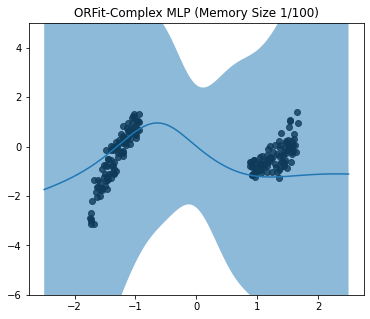

In [62]:
fig, ax = plt.subplots(figsize=(6, 5))
anim5 = animation.FuncAnimation(fig, animate_nlr4, frames=100)
# anim.save("orfit_mlp1.mp4", dpi=200, bitrate=-1, fps=24)

In [63]:
HTML(anim5.to_html5_video())

Time taken for step 100: 10.841744899749756


### 3.2.2 PPD Sweep over Training Set

#### 3.2.2.1 Memory Size 25

In [56]:
# Train Full-Memory ORFit on the dataset
orfit_params4 = ORFitParams(
    initial_mean=flat_params3,
    apply_function=apply_fn3,
    loss_function=lambda w, x, y: (apply_fn3(w, x) - y) ** 2,
    memory_size=25
)
orfit_posterior4 = orthogonal_recursive_fitting(orfit_params4, y2_train, X2_train)

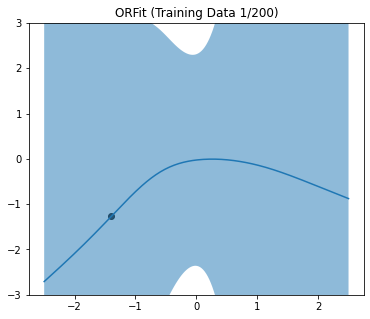

In [57]:
animate_nlr5 = lambda i: animate_orfit(orfit_posterior4, apply_fn3, lambda x: x, 
                                       X2_train, y2_train, X2_grid, None, True, 
                                       n2_train, i)

fig, ax = plt.subplots(figsize=(6, 5))
anim6 = animation.FuncAnimation(fig, animate_nlr5, frames=n2_train)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [58]:
HTML(anim6.to_html5_video())

#### 3.2.2.2 Infinite Memory

In [59]:
# Train Full-Memory ORFit on the dataset
orfit_params5 = ORFitParams(
    initial_mean=flat_params3,
    apply_function=apply_fn3,
    loss_function=lambda w, x, y: (apply_fn3(w, x) - y) ** 2,
    memory_size=n2_train
)
orfit_posterior5 = orthogonal_recursive_fitting(orfit_params5, y2_train, X2_train)

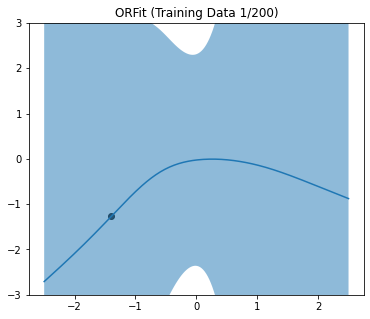

In [60]:
animate_nlr6 = lambda i: animate_orfit(orfit_posterior5, apply_fn3, lambda x: x, 
                                       X2_train, y2_train, X2_grid, None, True, 
                                       n2_train, i)

fig, ax = plt.subplots(figsize=(6, 5))
anim7 = animation.FuncAnimation(fig, animate_nlr6, frames=n2_train)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [61]:
HTML(anim7.to_html5_video())